In [40]:
!pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   -------- ------------------------------- 61.4/301.2 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 3.1 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

In [3]:
import pandas as pd

prior_order_df = pd.read_csv('./data/order_products__prior.csv')
prior_order_train_df = pd.read_csv('./data/order_products__train.csv')
order_df = pd.read_csv('./data/orders.csv')
product_df = pd.read_csv('./data/products.csv')
aisles_df = pd.read_csv('./data/aisles.csv')
department_df = pd.read_csv('./data/departments.csv')
sample_df = pd.read_csv('./data/sample_submission.csv') # 결과 도출하는 예시 파일

In [3]:
df = pd.read_csv('./data/data.csv')

## 데이터 EDA
- null값 확인
- 의미없는 컬럼 삭제

### Nan값 바꾸기

In [5]:
df.isnull().sum()

Unnamed: 0                      0
order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle                           0
department                      0
product_id                      0
add_to_cart_order               0
reordered                       0
aisle_id                        0
department_id                   0
dtype: int64

In [12]:
df[df['days_since_prior_order'].isnull() == True]['order_number'].unique()

array([1], dtype=int64)

nan값에 있는 값들은 모두 고객들이 처음 구매한 목록입니다. 즉, 첫 주문의 데이터이므로 삭제하지 않고 -1로 변환

In [6]:
df.fillna(-1, inplace=True)

In [8]:
df.isnull().sum()

Unnamed: 0                0
order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle                     0
department                0
product_id                0
add_to_cart_order         0
reordered                 0
aisle_id                  0
department_id             0
dtype: int64

### 필요없는 컬럼 제거

In [11]:
del df['Unnamed: 0']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_name            object 
 8   aisle                   object 
 9   department              object 
 10  product_id              int64  
 11  add_to_cart_order       int64  
 12  reordered               int64  
 13  aisle_id                int64  
 14  department_id           int64  
dtypes: float64(1), int64(10), object(4)
memory usage: 3.6+ GB


## 분석 시작
### 1. 가장 많이 주문된 데이터 확인하기

In [25]:
target = df['department'].value_counts()

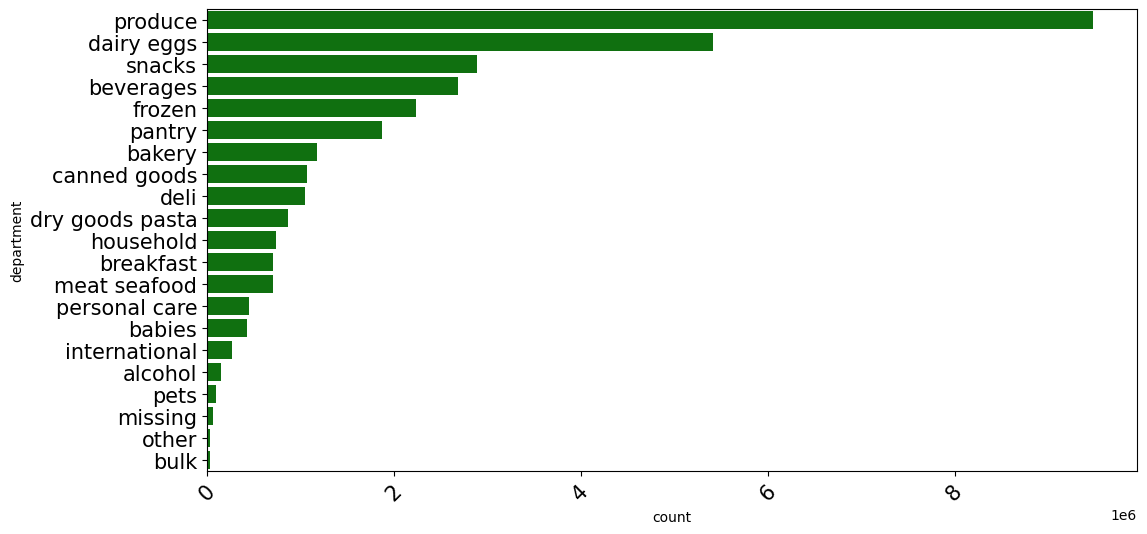

In [33]:
plt.figure(figsize=(12, 6))
order = df['department'].value_counts().index
sns.countplot(data=df, y='department', order=order, color='green')
# plt.title('department by last_cart_order')
# plt.xlabel('Count last_cart_order')
# plt.ylabel('department')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2. aisle(물품 중분류)을 활용하여 어떤 품목의 항목이 많이 팔리는지 확인

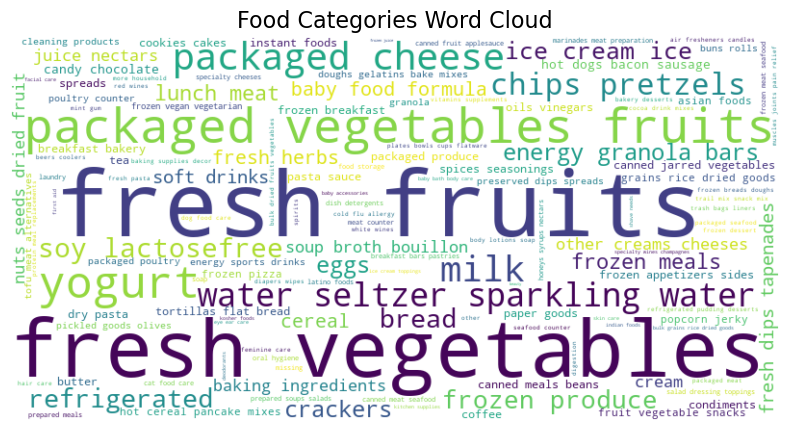

In [50]:
word_counts = df['aisle'].value_counts()

wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    colormap="viridis",
    prefer_horizontal=0.9
).generate_from_frequencies(word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Food Categories Word Cloud", fontsize=16)
plt.show()

### 3. 소분류 top_10 확인

---

In [15]:
df['product_name'].value_counts().head(10).to_frame()

,count
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
Organic Avocado,176815
Large Lemon,152657
Strawberries,142951
Limes,140627


### 3. 어떤 요일 및 시간대에 잘 팔리는지 heatmap을 통해 확인

---

주로 일요일(0), 월요일(1) 오전 10시 ~ 16시까지는 구매활동이 활발한 것으로 보입니다.

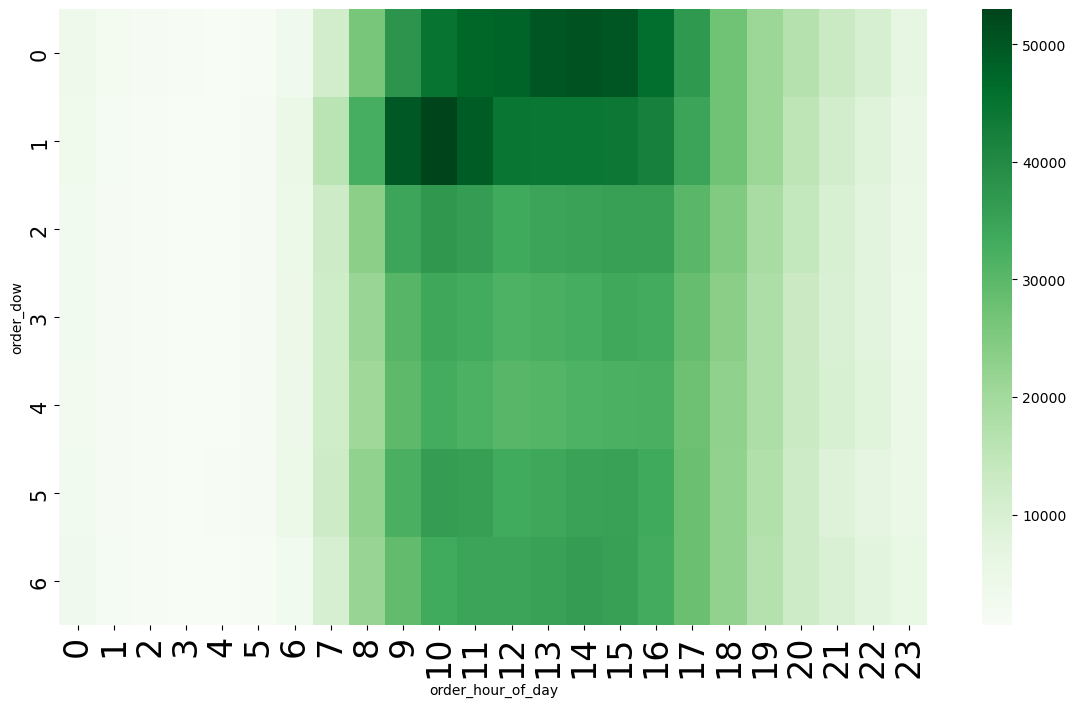

In [99]:
plt.figure(figsize=(14, 8))
a = df.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().unstack(fill_value=0)
sns.heatmap(data=a, cmap='Greens')
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=15)
plt.show()

### 재구매 비율 확인

---

In [59]:
all_order_count=len(df['reordered']) # 전체 주문 수 
reorder_count= len(df[df['reordered'] == 1]) # 전체 주문 수중 재주문 수
# 재주문 비율
value = reorder_count/all_order_count
other = 1 - value

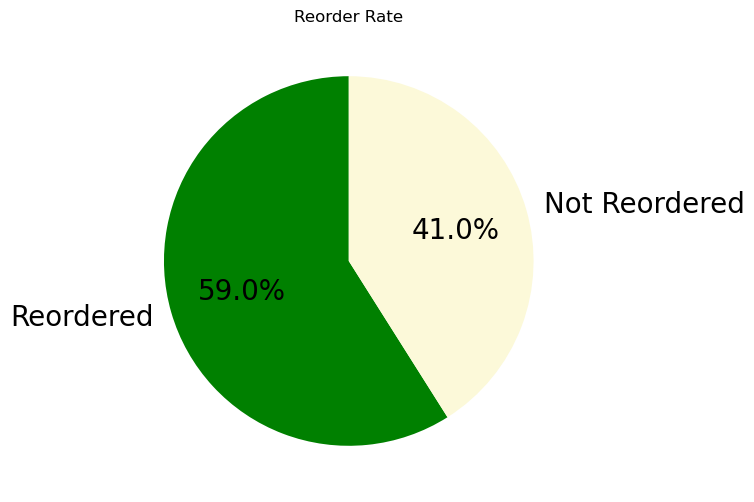

In [61]:
data = [value, other]
labels = ['Reordered', 'Not Reordered']

# 파이차트 생성
plt.figure(figsize=(6, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', colors=['green', '#fcf9d9'], startangle=90, textprops={'fontsize': 20})
plt.title('Reorder Rate')
plt.show()

### 재구매 주기 확인

---

- 재구매 주기는 주로 7일 마다 자주 일어나는 것으로 보입니다.
- 30일 주기가 많은 이유는 제 생각으로는 30일 이후 데이터들을 모두 30일에 포함 시켰기 때문에 높은 수치가 측정된 것으로 추측됩니다.

In [63]:
Ans = df[df['days_since_prior_order'] != -1]['days_since_prior_order'].value_counts().to_frame()

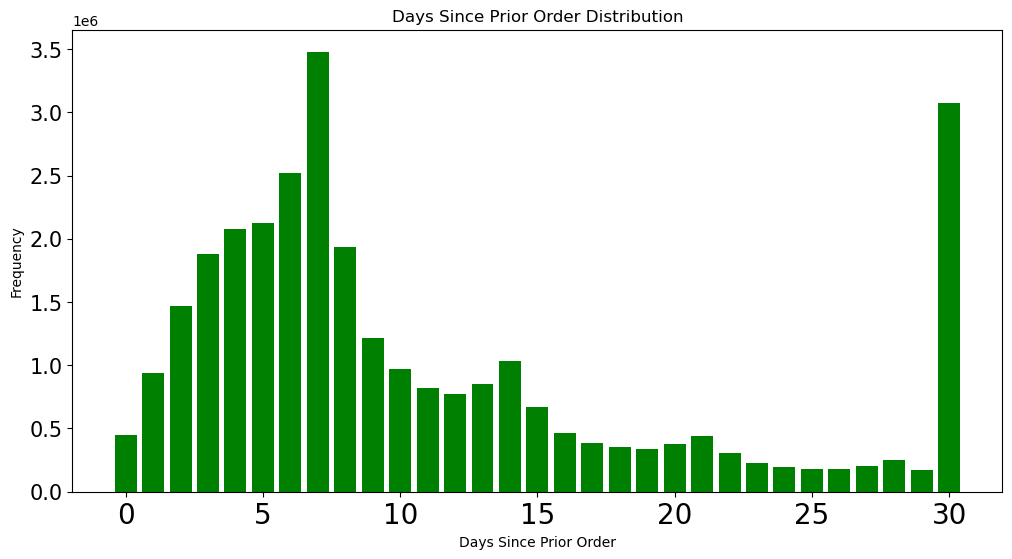

In [65]:
plt.figure(figsize=(12, 6))
plt.bar(Ans.index, Ans['count'], color='green')
plt.title('Days Since Prior Order Distribution')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()


### 주문 시 평균 장바구니 물품 수

---

<Axes: xlabel='add_to_cart_order'>

<Figure size 640x480 with 0 Axes>

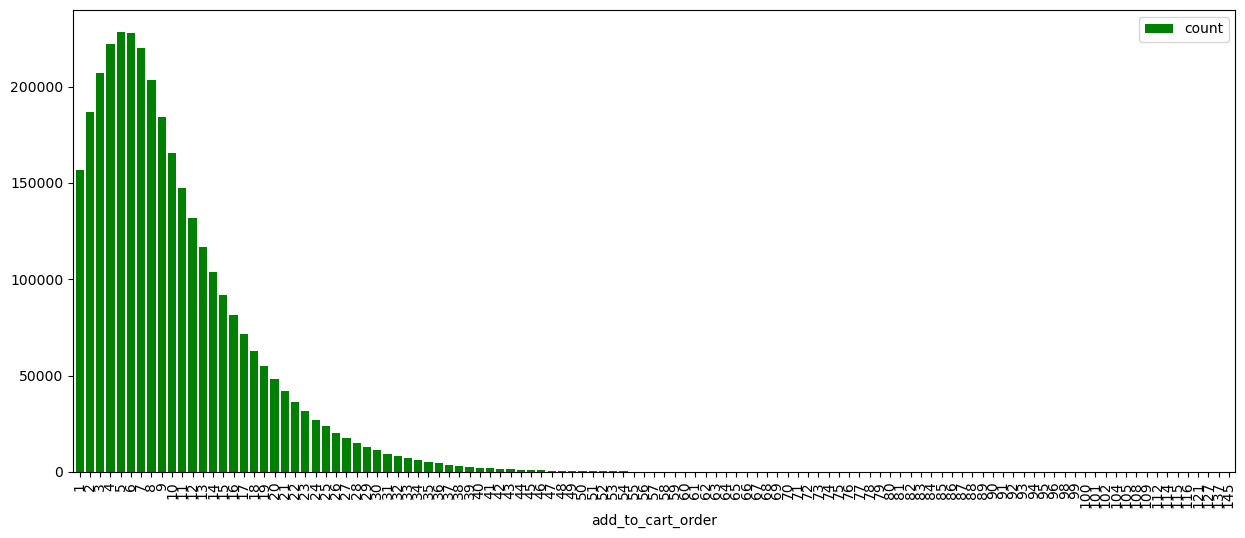

In [32]:
add_to_cart_count = df.groupby('order_id')['add_to_cart_order'].max().reset_index()
count_df = add_to_cart_count['add_to_cart_order'].value_counts().reset_index().sort_values(by='add_to_cart_order')
plt.figure()
count_df.plot(kind='bar', x='add_to_cart_order', y='count', figsize=(15, 6), color='green', width=0.8)

### 장바구니 순서에 따른 재구매율

---

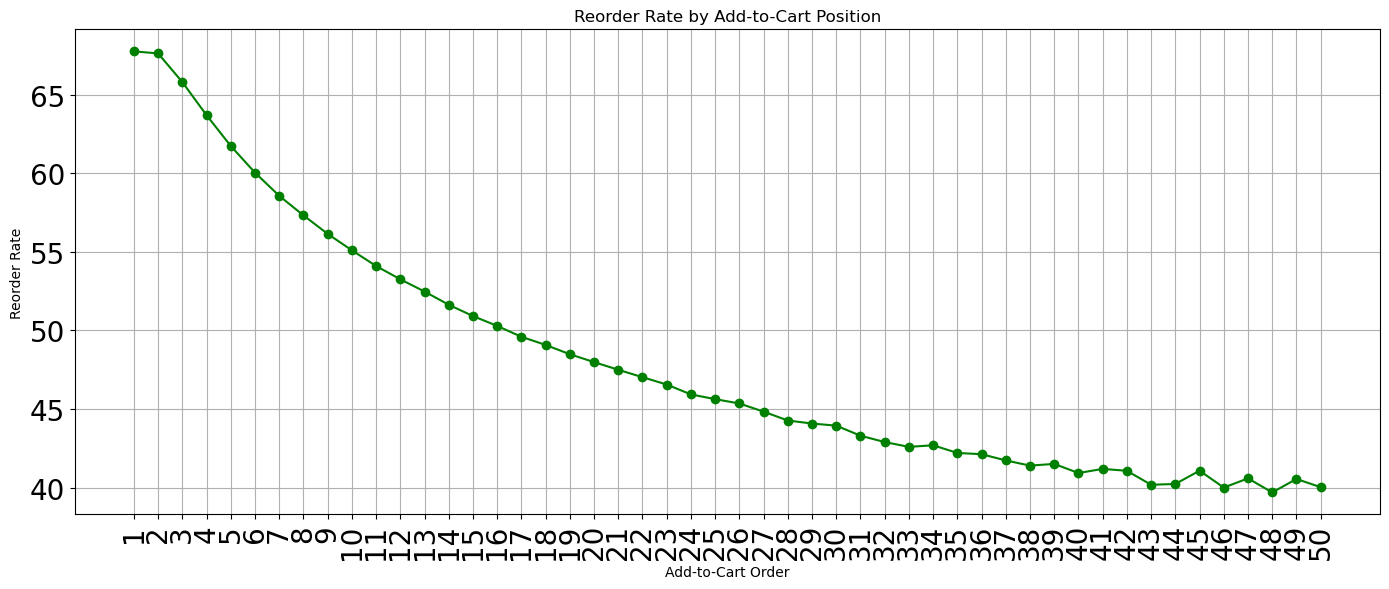

In [95]:
cart_order_reordered=df.groupby('add_to_cart_order')['reordered'].sum()
cart_order_reordered[cart_order_reordered.values >= 100]
cart_order_reordered_rate = df.groupby('add_to_cart_order')['reordered'].mean()*100

cart_order_reordered_rate = cart_order_reordered_rate[cart_order_reordered_rate.index <= 50]

plt.figure(figsize=(14,6))
plt.plot(cart_order_reordered_rate.index, cart_order_reordered_rate.values, marker='o', linestyle='-', c='g')
plt.xlabel("Add-to-Cart Order")
plt.ylabel("Reorder Rate")
plt.title("Reorder Rate by Add-to-Cart Position")
plt.xticks(range(1, 51), rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.grid()

### RFR 점수 기반 Segmentation

In [101]:
rfr_df = pd.read_csv('./data/RFR.csv')

In [103]:
rfr_df

,Unnamed: 0,user_id,recency,frequency,reordered
0,0,1,30.0,10,41
1,1,2,13.0,14,93
2,2,3,15.0,12,55
3,3,4,0.0,5,1
4,4,5,19.0,4,14
...,...,...,...,...,...
206204,206204,206205,10.0,3,8
206205,206205,206206,11.0,67,135
206206,206206,206207,18.0,16,131
206207,206207,206208,7.0,49,479


In [105]:
del rfr_df['Unnamed: 0']

In [107]:
# ▶ Min max scale = 최대값을 1, 최소값을 0으로 표준화하는 기법
from sklearn.preprocessing import minmax_scale

# ▶ 최근성은 숫자가 작을수록, 즉 최근 구매일이 얼마 지나지 않은 고객이 더 점수가 높음 그래서 1을 빼주었음.
rfr_df['recency'] = minmax_scale(rfr_df['recency'], axis=0, copy=True)
rfr_df['recency'] = 1-rfr_df['recency']

rfr_df['frequency'] = minmax_scale(rfr_df['frequency'], axis=0, copy=True)

rfr_df['reordered'] = minmax_scale(rfr_df['reordered'], axis=0, copy=True)

# ▶ Score
rfr_df['score']=rfr_df['recency']+rfr_df['frequency']+rfr_df['reordered']

# ▶ Score scaling 100 socre
rfr_df

,user_id,recency,frequency,reordered,score
0,1,0.000000,0.072917,0.012519,0.085436
1,2,0.566667,0.114583,0.028397,0.709647
2,3,0.500000,0.093750,0.016794,0.610544
3,4,1.000000,0.020833,0.000305,1.021139
4,5,0.366667,0.010417,0.004275,0.381358
...,...,...,...,...,...
206204,206205,0.666667,0.000000,0.002443,0.669109
206205,206206,0.633333,0.666667,0.041221,1.341221
206206,206207,0.400000,0.135417,0.040000,0.575417
206207,206208,0.766667,0.479167,0.146260,1.392093


In [109]:
# ▶ 100점을 곱해서 100점 만점으로 scaling
rfr_df['score']=minmax_scale(rfr_df['score'], axis=0, copy=True)*100
rfr_df['score']=round(rfr_df['score'],0)

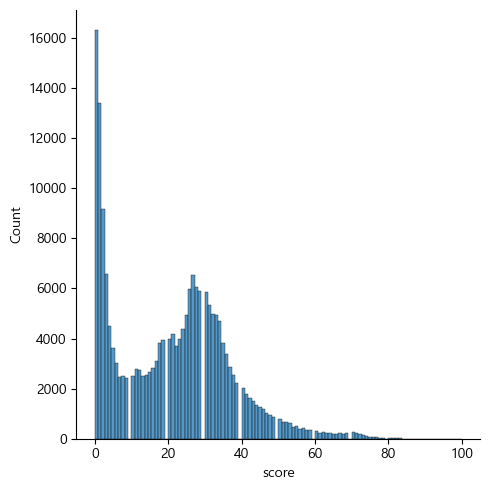

In [24]:
sns.displot(rfr_df['score']);

In [111]:
# ▶ 점수별로 고객의 등급을 부여
# 70점 이상 VIP
# 50~70점 최우수
# 30~50점 우수
# 10~30점 일반 고
# 0~10점 이탈 위험

rfr_df['grade'] = rfr_df['score'].apply(lambda x : 'VIP' if x>=70 else
                                  ('최우수' if x>=50 else
                                   ('우수' if x>=30 else
                                    ('일반' if x>=10 else '이탈 위험'))))
rfr_df

,user_id,recency,frequency,reordered,score,grade
0,1,0.000000,0.072917,0.012519,3.0,이탈 위험
1,2,0.566667,0.114583,0.028397,24.0,일반
2,3,0.500000,0.093750,0.016794,21.0,일반
3,4,1.000000,0.020833,0.000305,34.0,우수
4,5,0.366667,0.010417,0.004275,13.0,일반
...,...,...,...,...,...,...
206204,206205,0.666667,0.000000,0.002443,23.0,일반
206205,206206,0.633333,0.666667,0.041221,45.0,우수
206206,206207,0.400000,0.135417,0.040000,19.0,일반
206207,206208,0.766667,0.479167,0.146260,47.0,우수


In [113]:
rfr_df['grade'].value_counts()

grade
일반       79099
이탈 위험    64030
우수       54286
최우수       7542
VIP       1252
Name: count, dtype: int64

고객 등급별 비율 확인

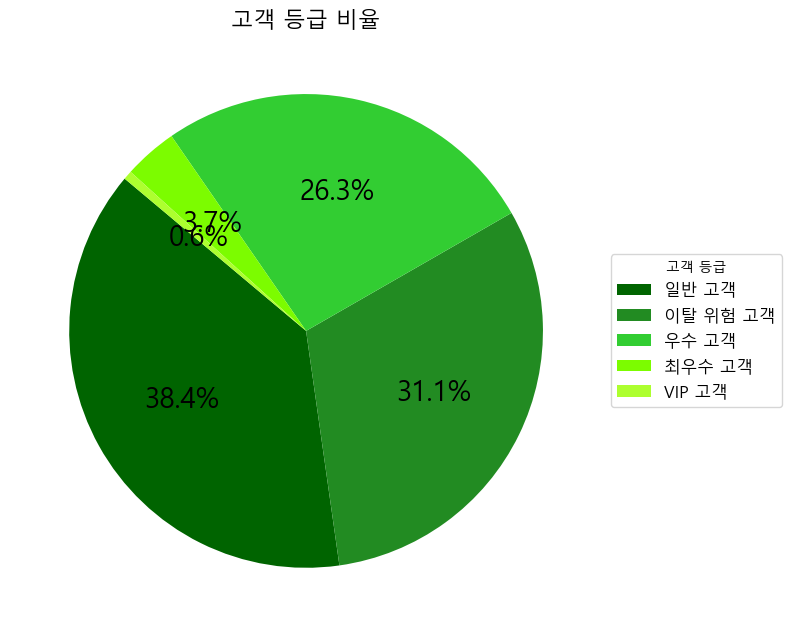

In [145]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 한글 폰트를 설정
rcParams['font.family'] = 'Malgun Gothic'

# 각 등급별 데이터 수 계산
grade_counts = rfr_df['grade'].value_counts()

# 색상 설정
colors = ['#006400', '#228B22', '#32CD32', '#7CFC00', '#ADFF2F']

# 파이차트 그리기
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    grade_counts,
    # labels=grade_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    # textprops={'color': 'black'},
    textprops={'fontsize': 20}
)

# 텍스트 크기 조정
# for text in texts:
#     text.set_fontsize(12)
# for autotext in autotexts:
#     autotext.set_fontsize(12)

# 범례 추가
plt.legend(wedges, grade_counts.index + " 고객", title="고객 등급", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

# 제목 추가
plt.title('고객 등급 비율', fontsize=16)

# 그래프 표시
plt.tight_layout()
plt.show()


In [147]:
df.shape

(32434489, 15)

In [149]:
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_name', 'aisle',
       'department', 'product_id', 'add_to_cart_order', 'reordered',
       'aisle_id', 'department_id'],
      dtype='object')

In [151]:
df = df.merge(rfr_df, on='user_id', how='left')

In [33]:
df.to_csv('merge.csv', index=False)

In [35]:
test = pd.read_csv('merge.csv')
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department,product_id,add_to_cart_order,reordered_x,aisle_id,department_id,recency,frequency,reordered_y,score,grade
0,2539329,1,prior,1,2,8,-1.0,Soda,soft drinks,beverages,196,1,0,77,7,0.0,0.072917,0.012519,3.0,이탈 위험
1,2539329,1,prior,1,2,8,-1.0,Organic Unsweetened Vanilla Almond Milk,soy lactosefree,dairy eggs,14084,2,0,91,16,0.0,0.072917,0.012519,3.0,이탈 위험
2,2539329,1,prior,1,2,8,-1.0,Original Beef Jerky,popcorn jerky,snacks,12427,3,0,23,19,0.0,0.072917,0.012519,3.0,이탈 위험
3,2539329,1,prior,1,2,8,-1.0,Aged White Cheddar Popcorn,popcorn jerky,snacks,26088,4,0,23,19,0.0,0.072917,0.012519,3.0,이탈 위험
4,2539329,1,prior,1,2,8,-1.0,XL Pick-A-Size Paper Towel Rolls,paper goods,household,26405,5,0,54,17,0.0,0.072917,0.012519,3.0,이탈 위험


### 그룹별 인기 있는 중분류 대분류 소분류 상품

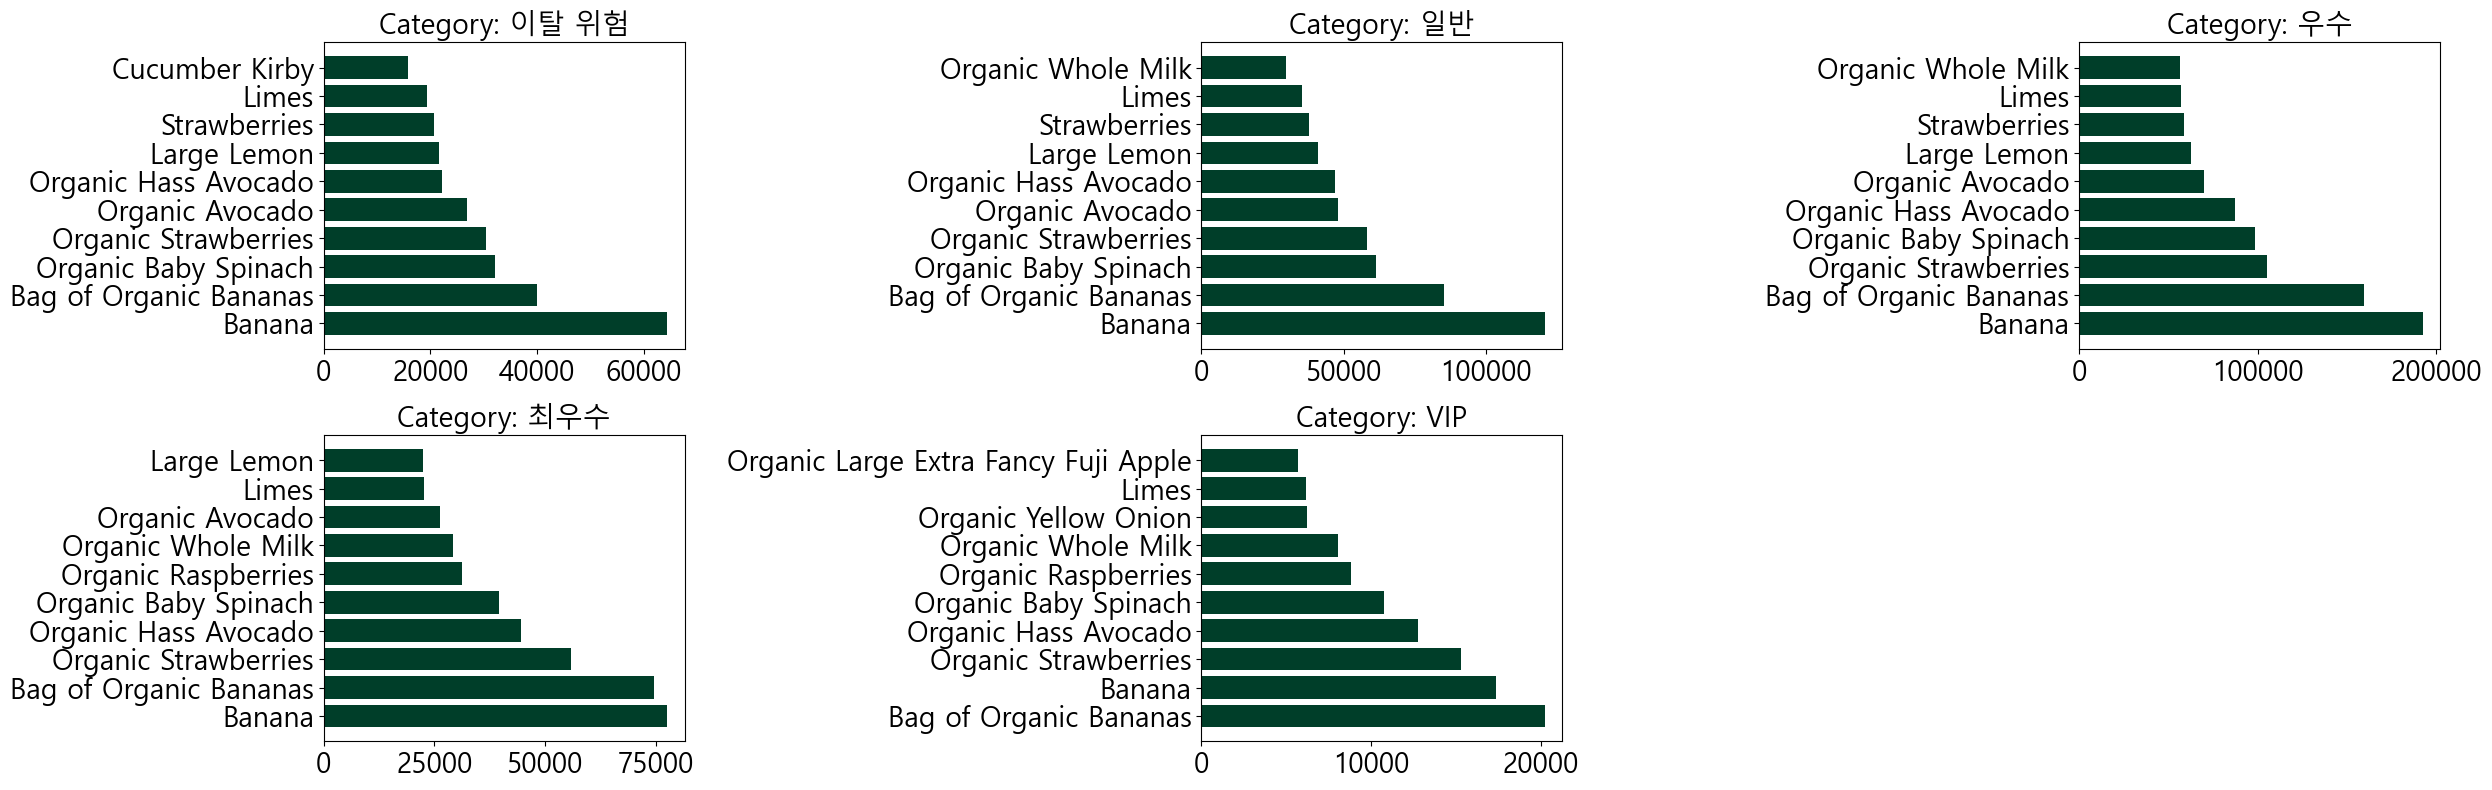

In [159]:
# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(2, 3, figsize=(25, 8))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    dept_df = cate_df['product_name'].value_counts().head(10).reset_index()
    axes[idx].barh(dept_df['product_name'], dept_df['count'], color='#003E29', height=0.8)
    axes[idx].set_title(f'Category: {i}', fontsize=20)  # 제목 폰트 크기 설정
    axes[idx].tick_params(axis='x', labelsize=20)  # x축 라벨 폰트 크기 설정
    axes[idx].tick_params(axis='y', labelsize=20)  # y축 라벨 폰트 크기 설정

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.savefig('image.png')
plt.show()


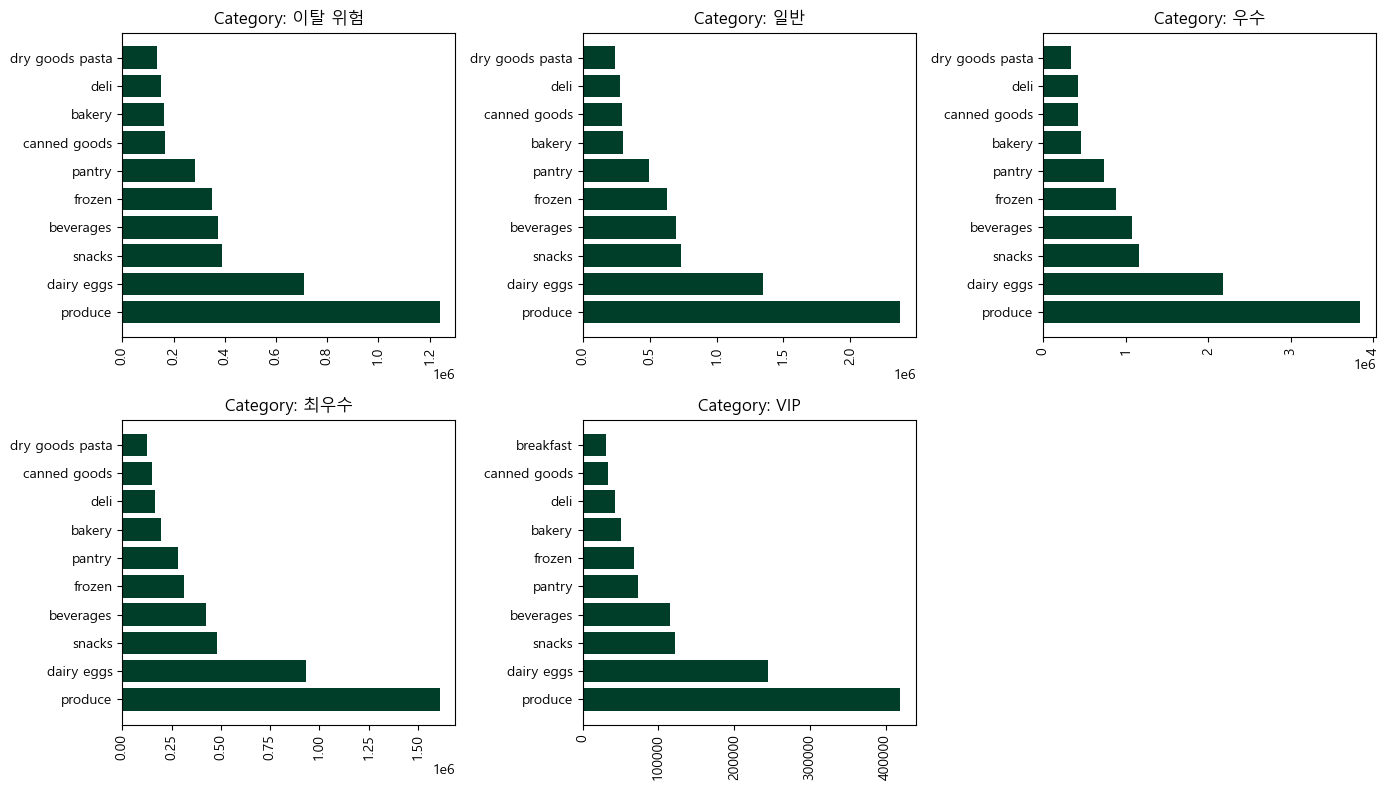

In [60]:
# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    dept_df = cate_df['department'].value_counts().head(10).reset_index()
    axes[idx].barh(dept_df['department'], dept_df['count'], color='#003E29', height=0.8)
    axes[idx].set_title(f'Category: {i}')
    axes[idx].tick_params(axis='x', rotation=90)

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.show()

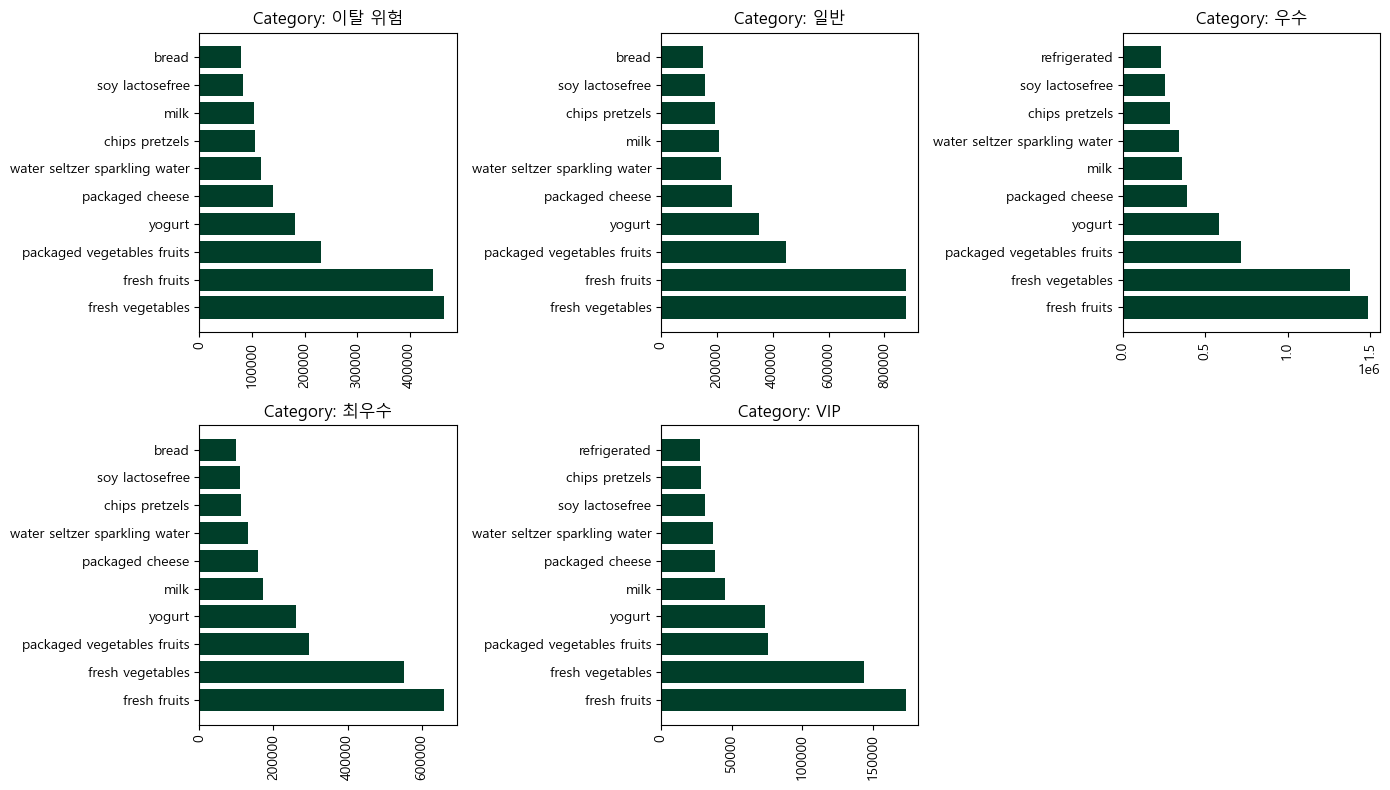

In [68]:
# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    dept_df = cate_df['aisle'].value_counts().head(10).reset_index()
    axes[idx].barh(dept_df['aisle'], dept_df['count'], color='#003E29', height=0.8)
    axes[idx].set_title(f'Category: {i}')
    axes[idx].tick_params(axis='x', rotation=90)

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.show()

### 고객 등급별 주문 시간에 따른 행동 분석

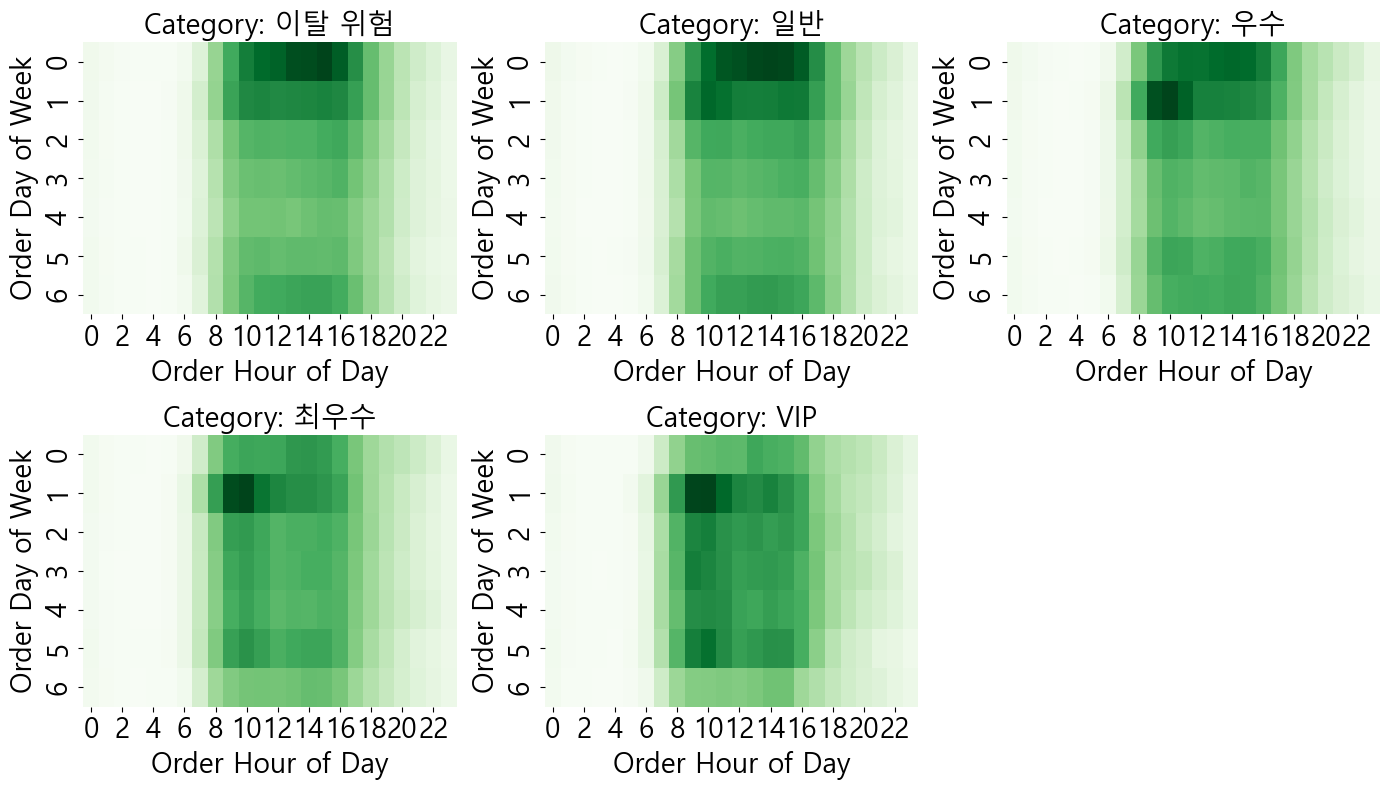

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn import 필요

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):
    cate_df = df[df['grade'] == i]
    dept_df = cate_df.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().unstack(fill_value=0)
    
    # Seaborn의 heatmap을 각 서브플롯에 적용
    sns.heatmap(data=dept_df, ax=axes[idx], cmap='Greens', cbar=False)
    
    # 제목, x축, y축 폰트 크기 설정
    axes[idx].set_title(f'Category: {i}', fontsize=20)  # 제목 폰트 크기
    axes[idx].set_xlabel('Order Hour of Day', fontsize=20)  # x축 폰트 크기
    axes[idx].set_ylabel('Order Day of Week', fontsize=20)  # y축 폰트 크기
    
    # x축, y축 틱 라벨 폰트 크기 설정
    axes[idx].tick_params(axis='x', labelsize=20)  # x축 폰트 크기
    axes[idx].tick_params(axis='y', labelsize=20)  # y축 폰트 크기

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.savefig('image2.png')
plt.show()


### 고객 등급별 재구매 비율

In [173]:
df.groupby('grade')['reordered_x'].mean()

grade
VIP      0.794308
우수       0.627265
이탈 위험    0.405420
일반       0.497463
최우수      0.749988
Name: reordered_x, dtype: float64

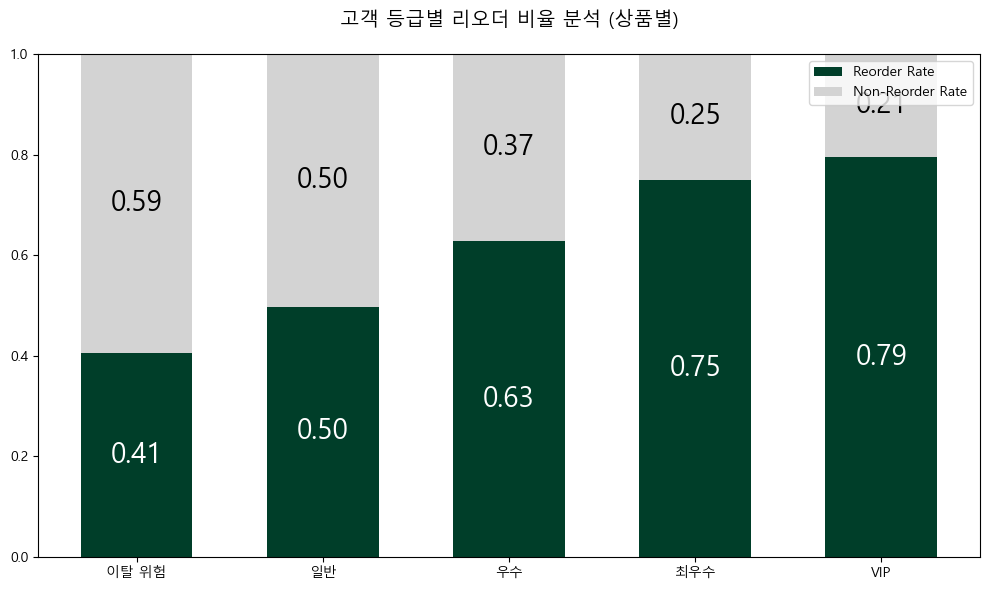

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# list_df 예시 (실제 데이터로 대체)
list_df = pd.DataFrame({
    'grade': ['VIP', '우수', '이탈 위험', '일반', '최우수'],
    'reorder_rate': [0.794308, 0.627265, 0.405420, 0.497463, 0.749988]
})

# 'grade' 순서를 설정 (변경된 순서)
order = ['이탈 위험', '일반', '우수', '최우수', 'VIP']  # 새로 설정한 순서
list_df['grade'] = pd.Categorical(list_df['grade'], categories=order, ordered=True)

# 데이터를 'grade' 순서대로 정렬
list_df = list_df.sort_values('grade')

# non_reorder_rate 계산
list_df['non_reorder_rate'] = 1 - list_df['reorder_rate']

# 데이터 준비
categories = list_df['grade']  # 등급 이름
reorder_rates = list_df['reorder_rate']  # 재주문 비율
non_reorder_rates = list_df['non_reorder_rate']  # 비재주문 비율

# 막대 너비 설정
bar_width = 0.6

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(10, 6))

# x 좌표 생성
x = np.arange(len(categories))

# 스택형 막대 그래프 생성
bar1 = ax.bar(x, reorder_rates, bar_width, label="Reorder Rate", color="#003E29")
bar2 = ax.bar(x, non_reorder_rates, bar_width, bottom=reorder_rates, label="Non-Reorder Rate", color="lightgray")

# 각 막대의 중앙에 텍스트 추가
for i, (bar, reorder, non_reorder) in enumerate(zip(bar1, reorder_rates, non_reorder_rates)):
    # 재주문 비율 텍스트: 막대의 중앙에 위치
    ax.text(bar.get_x() + bar.get_width() / 2, reorder / 2, f'{reorder:.2f}', 
            ha='center', va='center', color='white', fontsize=20)

    # 비재주문 비율 텍스트: 막대의 중앙에 위치 (비재주문 비율은 stacked 막대의 중앙)
    ax.text(bar.get_x() + bar.get_width() / 2, reorder + non_reorder / 2, f'{non_reorder:.2f}', 
            ha='center', va='center', color='black', fontsize=20)

# x축 설정
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=0)

# y축 범위 설정
ax.set_ylim(0, 1)

# 제목 및 범례
ax.set_title("고객 등급별 리오더 비율 분석 (상품별)", fontsize=14, pad=20)
ax.legend(loc="upper right", fontsize=10)

# 여백 조정 및 그래프 표시
plt.tight_layout()
plt.savefig('image3.png')
plt.show()


### 등급별 인기있는 재구매 상품 확인

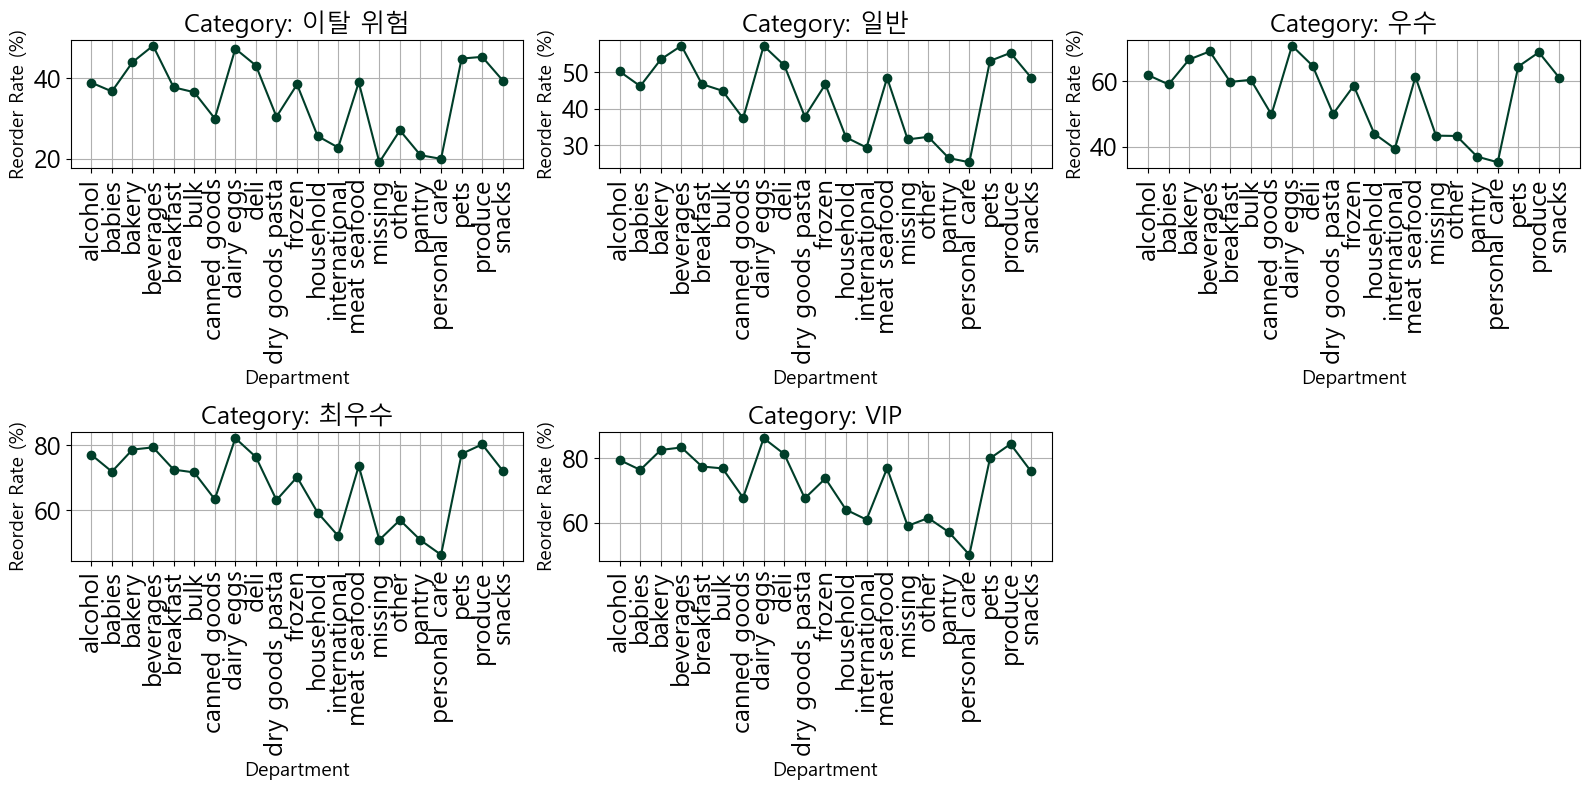

In [197]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (2x3)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    dept_reordered_df = cate_df.groupby('department')['reordered_x'].mean() * 100
    axes[idx].plot(dept_reordered_df.index, dept_reordered_df.values, color='#003E29', marker='o')
    axes[idx].set_title(f'Category: {i}', fontsize=18)  # 제목 폰트 크기 설정
    axes[idx].tick_params(axis='x', rotation=90, labelsize=18)  # x축 폰트 크기 설정
    axes[idx].tick_params(axis='y', labelsize=18)  # y축 폰트 크기 설정
    axes[idx].set_xlabel('Department', fontsize=14)  # x축 레이블 폰트 크기 설정
    axes[idx].set_ylabel('Reorder Rate (%)', fontsize=14)  # y축 레이블 폰트 크기 설정
    axes[idx].grid()

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.savefig('image4.png')
plt.show()


### 고객 등급별 재구매 주기 확인

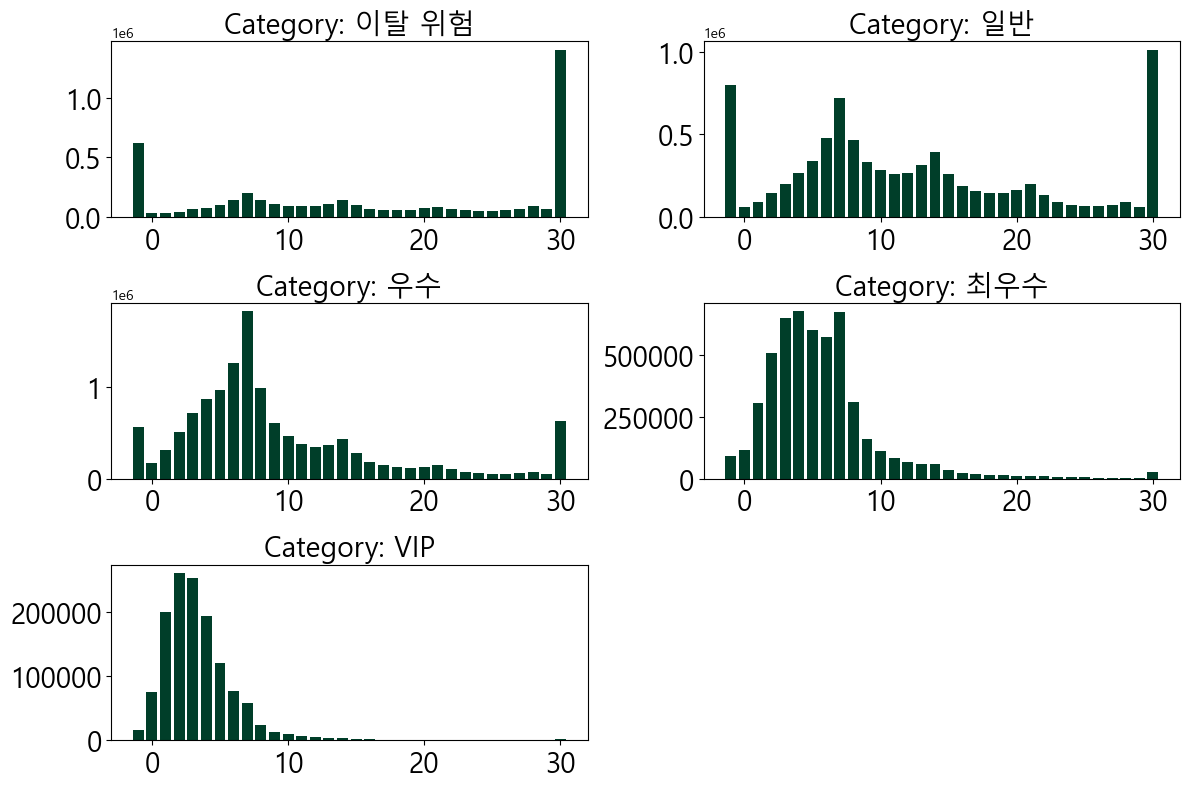

In [205]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))  # 전체 크기 조정
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    count_df = cate_df['days_since_prior_order'].value_counts().reset_index().sort_values(by='days_since_prior_order')
    
    # 막대 그래프 생성
    axes[idx].bar(count_df['days_since_prior_order'], count_df['count'], color='#003E29', width=0.8)
    
    # 제목 설정
    axes[idx].set_title(f'Category: {i}', fontsize=20)  # 제목 폰트 크기 설정
    
    # x축, y축 레이블 폰트 크기 설정
    # axes[idx].set_xlabel('Days Since Prior Order', fontsize=20)
    # axes[idx].set_ylabel('Count', fontsize=20)

    # x, y축 폰트 크기 설정
    axes[idx].tick_params(axis='x', labelsize=20)  # x축 폰트 크기 설정
    axes[idx].tick_params(axis='y', labelsize=20)  # y축 폰트 크기 설정

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.savefig('image5.png')
plt.show()


### 고객등급별 주문 시 담는 물품 수

In [50]:
for i in df['grade'].unique():
    cate_df = df[df['grade'] == i]
    print(i)
    add_to_cart_count = cate_df.groupby('order_id')['add_to_cart_order'].max().reset_index()
    print('주문 시 담는 평균 개수:', round(add_to_cart_count['add_to_cart_order'].mean(), 2))

이탈 위험
주문 시 담는 평균 개수: 9.53
일반
주문 시 담는 평균 개수: 10.05
우수
주문 시 담는 평균 개수: 10.12
최우수
주문 시 담는 평균 개수: 10.38
VIP
주문 시 담는 평균 개수: 11.01


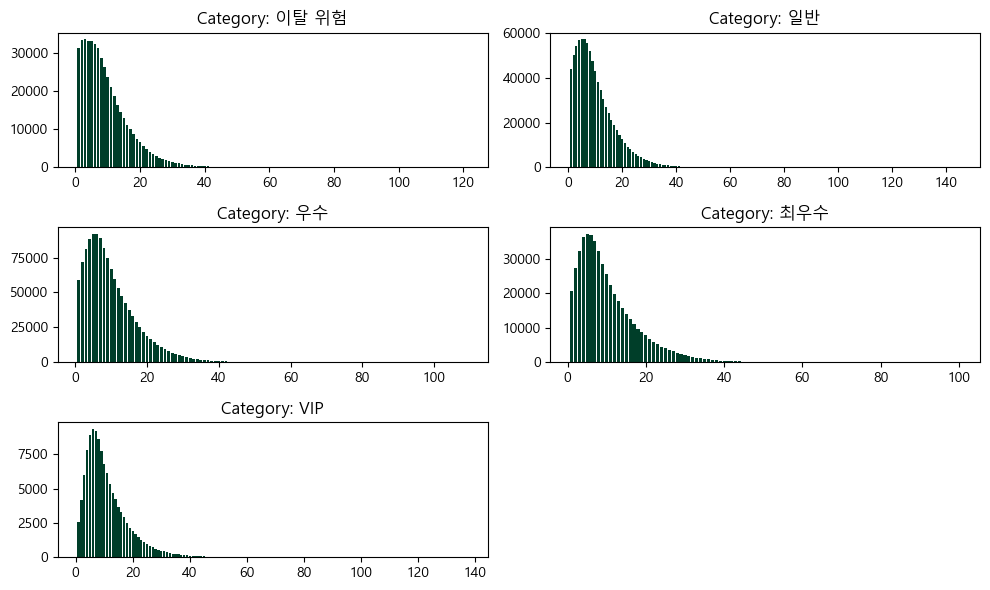

In [48]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 서브플롯 크기 설정 (3x2)
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
axes = axes.flatten()  # 서브플롯을 1차원 배열로 변환

# 카테고리별로 반복
for idx, i in enumerate(df['grade'].unique()):

    cate_df = df[df['grade'] == i]
    add_to_cart_count = cate_df.groupby('order_id')['add_to_cart_order'].max().reset_index()
    count_df = add_to_cart_count['add_to_cart_order'].value_counts().reset_index().sort_values(by='add_to_cart_order')
    axes[idx].bar(count_df['add_to_cart_order'], count_df['count'], color='#003E29', width=0.8)
    axes[idx].set_title(f'Category: {i}')

# 남은 빈 서브플롯 숨기기
for j in range(idx + 1, 6):
    axes[j].axis('off')

# 서브플롯 간 여백 조정
plt.tight_layout()
plt.show()

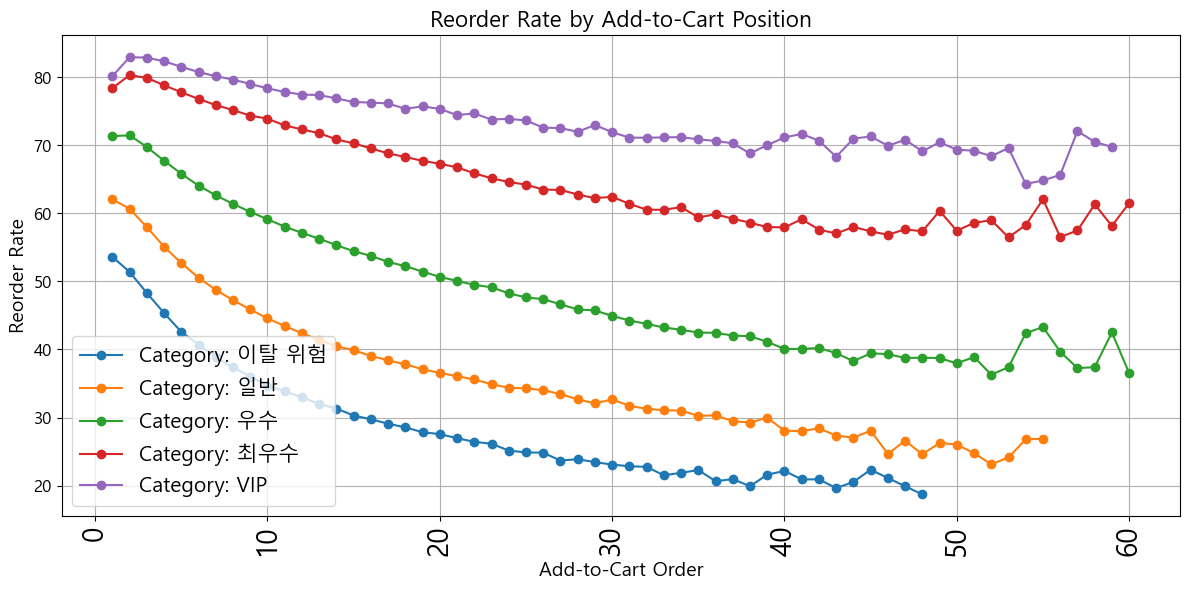

In [61]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 카테고리별로 반복
for i in df['grade'].unique():
    cate_df = df[df['grade'] == i]
    # 카트에 넣는 순서 기준으로 재주문 되는 횟수 측정
    cart_order_reordered = cate_df.groupby('add_to_cart_order')['reordered_x'].sum()
    
    # 재주문 비율 계산
    cart_order_reordered_rate = cate_df.groupby('add_to_cart_order')['reordered_x'].mean() * 100
    
    # 재주문 횟수가 100개 이상인 카트 넣는 숫자들만 가져오기
    cart_order_reordered_rate = cart_order_reordered_rate[
        cart_order_reordered_rate.index <= cart_order_reordered[cart_order_reordered.values >= 100].index[-1]
    ]
    # 그래프 그리기
    plt.plot(
        cart_order_reordered_rate.index,
        cart_order_reordered_rate.values,
        marker='o',
        linestyle='-',
        label=f'Category: {i}'
    )

# 그래프 제목 및 축 레이블 설정 (폰트 크기 조정)
plt.xlabel("Add-to-Cart Order", fontsize=14)  # X축 레이블 크기
plt.ylabel("Reorder Rate", fontsize=14)      # Y축 레이블 크기
plt.title("Reorder Rate by Add-to-Cart Position", fontsize=16)  # 제목 크기
plt.xticks( fontsize=20, rotation=90)  # X축 눈금 크기
plt.yticks(fontsize=12)  # Y축 눈금 크기

# 범례 표시
plt.legend(fontsize=15)  # 범례 크기
plt.grid()

# 그래프 간 여백 조정
plt.tight_layout()
plt.show()


In [63]:
from scipy.stats import pointbiserialr

def pointbiserialr_calc(reordered, column):
    correlation, p_value = pointbiserialr(df[reordered], df[column])

    print(f"{column}과 {reordered}의 포인트 바이세리얼 상관계수: {round(correlation, 6)}")
    # print("p-value:", p_value)

In [65]:
df.columns

Index(['Unnamed: 0', 'order_id', 'user_id', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'product_name', 'aisle', 'department', 'product_id',
       'add_to_cart_order', 'reordered_x', 'aisle_id', 'department_id',
       'recency', 'frequency', 'reordered_y', 'score', 'grade'],
      dtype='object')

In [71]:
columns = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order','aisle_id','department_id', 'score', 'recency', 'frequency', 'reordered_y']

In [73]:
for i in columns:
    pointbiserialr_calc('reordered_x', i)
    print()

order_number과 reordered_x의 포인트 바이세리얼 상관계수: 0.30684

order_dow과 reordered_x의 포인트 바이세리얼 상관계수: -0.006949

order_hour_of_day과 reordered_x의 포인트 바이세리얼 상관계수: -0.0233

days_since_prior_order과 reordered_x의 포인트 바이세리얼 상관계수: -0.015715

product_id과 reordered_x의 포인트 바이세리얼 상관계수: 0.003718

add_to_cart_order과 reordered_x의 포인트 바이세리얼 상관계수: -0.133024

aisle_id과 reordered_x의 포인트 바이세리얼 상관계수: 0.003924

department_id과 reordered_x의 포인트 바이세리얼 상관계수: -0.039371

score과 reordered_x의 포인트 바이세리얼 상관계수: 0.245193

recency과 reordered_x의 포인트 바이세리얼 상관계수: 0.14839

frequency과 reordered_x의 포인트 바이세리얼 상관계수: 0.254417

reordered_y과 reordered_x의 포인트 바이세리얼 상관계수: 0.259223



C:\Users\min99\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\min99\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


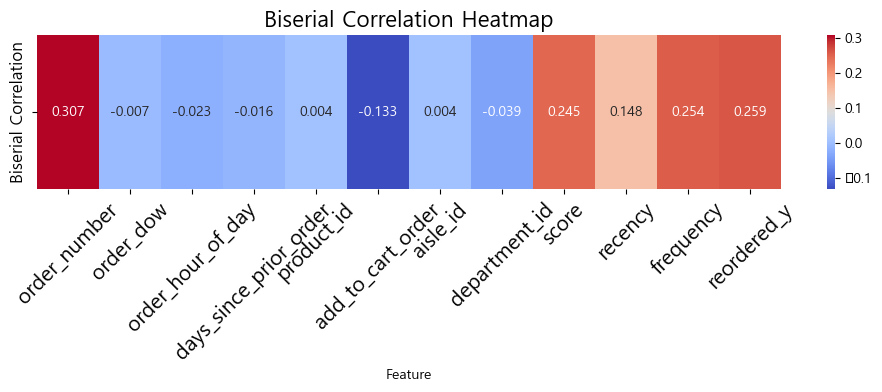

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 바이시리얼 상관계수 데이터를 데이터프레임으로 생성
data = {
    "Feature": [
        "order_number", "order_dow", "order_hour_of_day",
        "days_since_prior_order", "product_id", "add_to_cart_order",
        "aisle_id", "department_id", "score", "recency",
        "frequency", "reordered_y"
    ],
    "Biserial Correlation": [
        0.30684, -0.006949, -0.0233, -0.015715, 0.003718,
        -0.133024, 0.003924, -0.039371, 0.245193, 0.14839,
        0.254417, 0.259223
    ]
}

df2 = pd.DataFrame(data)

# 히트맵을 위한 피벗 테이블 생성
heatmap_data = df2.set_index("Feature").T

# 히트맵 그리기
plt.figure(figsize=(12, 2))  # 그래프 크기 설정
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".3f", cbar=True)

# 그래프 제목 설정
plt.title("Biserial Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, fontsize=15)  # X축 글자 회전 및 크기 설정
plt.yticks(fontsize=12)  # Y축 글자 크기 설정
plt.show()


In [37]:
import pandas as pd

# 1. 유저별 총 주문 횟수 (u_num_of_orders)
user_order_counts = df.groupby('user_id')['order_id'].nunique().reset_index()
user_order_counts.columns = ['user_id', 'u_num_of_orders']

# 2. 유저당 평균 구매 제품 수 (u_avg_prd)
user_avg_products = df.groupby('user_id')['product_id'].count() / user_order_counts['u_num_of_orders']
user_avg_products = user_avg_products.reset_index()
user_avg_products.columns = ['user_id', 'u_avg_prd']

# 3. 제품별 총 구매 횟수 (p_num_of_times)
product_counts = df.groupby('product_id')['order_id'].count().reset_index()
product_counts.columns = ['product_id', 'p_num_of_times']

# 4. 제품별 재구매 비율 (p_reorder_ratio)
product_reorder_ratio = df.groupby('product_id')['reordered_x'].mean().reset_index()
product_reorder_ratio.columns = ['product_id', 'p_reorder_ratio']

# 5. 특정 user_id와 product_id의 구매 횟수 (uxp_times_bought)
user_product_counts = df.groupby(['user_id', 'product_id']).size().reset_index(name='uxp_times_bought')

# 6. 유저가 특정 제품을 재구매한 비율 (uxp_reorder_ratio)
user_product_reorder = df.groupby(['user_id', 'product_id'])['reordered_x'].mean().reset_index()
user_product_reorder.columns = ['user_id', 'product_id', 'uxp_reorder_ratio']

# 7. 최근 주문 주기 (recency): 특정 제품이 마지막으로 주문된 지 얼마나 되었는지
product_recency = df.groupby(['user_id', 'product_id'])['recency'].mean().reset_index()
product_recency.columns = ['user_id', 'product_id', 'product_recency']

# 8. 구매 빈도 (frequency): 특정 제품의 구매 빈도
product_frequency = df.groupby(['user_id', 'product_id'])['frequency'].mean().reset_index()
product_frequency.columns = ['user_id', 'product_id', 'product_frequency']

# 9. 점수(score)와 등급(grade)을 사용하여 특정 제품의 점수 기반 Feature 생성
product_score = df.groupby('product_id')['score'].mean().reset_index()
product_score.columns = ['product_id', 'avg_product_score']

# 한글 grade 값을 숫자로 변환
grade_mapping = {'VIP': 4, '최우수': 3, '우수': 2, '일반': 1, '이탈 위험':0}
df['grade'] = df['grade'].map(grade_mapping)

# NaN 처리
df['grade'].fillna(0, inplace=True)

# 유저별 평균 등급 계산
user_grade = df.groupby('user_id')['grade'].mean().reset_index()
user_grade.columns = ['user_id', 'avg_user_grade']

# 각 product_id별로 장바구니에 추가된 평균 위치입니다
product_add_to_cart_ratio = df.groupby('product_id')['add_to_cart_order'].mean().reset_index()
product_add_to_cart_ratio.columns = ['product_id', 'product_add_to_cart_ratio']

# 각 user_id별로 재주문된 비율입니다
user_reorder_ratio = df.groupby('user_id')['reordered_x'].mean().reset_index()
user_reorder_ratio.columns = ['user_id', 'u_reorder_ratio']

# Merge Features (기준: user_id와 product_id)
features = pd.merge(df, user_order_counts, on='user_id', how='left')
features = pd.merge(features, user_avg_products, on='user_id', how='left')
features = pd.merge(features, product_counts, on='product_id', how='left')
features = pd.merge(features, product_reorder_ratio, on='product_id', how='left')
features = pd.merge(features, user_product_counts, on=['user_id', 'product_id'], how='left')
features = pd.merge(features, user_product_reorder, on=['user_id', 'product_id'], how='left')
features = pd.merge(features, product_recency, on=['user_id', 'product_id'], how='left')
features = pd.merge(features, product_frequency, on=['user_id', 'product_id'], how='left')
features = pd.merge(features, product_score, on='product_id', how='left')
features = pd.merge(features, user_grade, on='user_id', how='left')
features = pd.merge(features, product_add_to_cart_ratio, on='product_id', how='left')
features = pd.merge(features, user_reorder_ratio, on='user_id', how='left')

# NaN 처리 (재구매 예측 문제에 맞게 NaN을 0으로 처리)
features.fillna(0, inplace=True)

# 최종 데이터 확인
# features.to_csv('Features.csv', index=False)


C:\Users\min99\AppData\Local\Temp\ipykernel_23388\2401618085.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['grade'].fillna(0, inplace=True)


In [41]:
features.to_csv('Features.csv', index=False)

In [27]:
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_name', 'aisle',
       'department', 'product_id', 'add_to_cart_order', 'reordered_x',
       'aisle_id', 'department_id', 'recency', 'frequency', 'reordered_y',
       'score'],
      dtype='object')

In [ ]:
features.drop(columns=['eval_set', 'department','product_name', 'aisle'], axis=1)